In [37]:
%%bash

# 增加更新
git add *.ipynb

git remote -v

git commit -m '更新 ch9 #1 change Jul 31, 2021'

git push origin master

origin	git@github.com:ustchope/dlwpn.git (fetch)
origin	git@github.com:ustchope/dlwpn.git (push)
[master aa499b4] 更新 ch9 #1 change Jul 31, 2021
 1 file changed, 1060 insertions(+), 43 deletions(-)


To github.com:ustchope/dlwpn.git
   1dc5825..aa499b4  master -> master


In [2]:
# 自动计算cell的计算时间
%load_ext autotime

time: 503 µs (started: 2021-07-31 22:18:53 +08:00)


In [3]:
#设置使用的gpu
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")

if gpus:
   
    gpu0 = gpus[0] #如果有多个GPU，仅使用第0个GPU
    tf.config.experimental.set_memory_growth(gpu0, True) #设置GPU显存用量按需使用
    # 或者也可以设置GPU显存为固定使用量(例如：4G)
    #tf.config.experimental.set_virtual_device_configuration(gpu0,
    #    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]) 
    tf.config.set_visible_devices([gpu0],"GPU") 

time: 6.47 s (started: 2021-07-31 22:18:55 +08:00)


In [4]:
%config InlineBackend.figure_format='svg' #矢量图设置，让绘图更清晰

time: 24.5 ms (started: 2021-07-31 22:19:02 +08:00)


# 用于计算机视觉的高级深度学习

> 本章包含

* 计算机视觉的不同分支：图像分类、图像分割、对象检测
* 现代卷积网络架构模式：残差连接、批量归一化、深度可分离卷积
* 可视化和解释卷积神经网络所学内容的技术

前一章通过简单的模型（Conv2D 和 MaxPooling2D 层的堆栈）和一个简单的用例（二值图像分类）首次介绍了计算机视觉的深度学习。 但是计算机视觉不仅仅是图像分类！ 本章深入探讨更多样化的应用程序和高级最佳实践。

## 三个基本的计算机视觉任务

到目前为止，我们一直专注于图像分类模型：输入图像，输出标签。 “这张图片可能包含一只猫，另一张图片可能包含一只狗”。 但图像分类只是深度学习在计算机视觉中的几种可能应用之一。 一般来说，您需要了解三个基本的计算机视觉任务：
* **图像分类**——目标是为图像分配一个或多个标签。 它可以是单标签分类（一幅图像只能属于一个类别而排除其他类别），也可以是多标签分类（标记图像所属的所有类别，如图 9.1 所示）。 例如，当您在 Google 相册应用中搜索关键字时，您在后台查询的是一个非常大的多标签分类模型——该模型具有超过 20,000 个不同的类别，并在数百万张图像上进行训练。
* **图像分割**——目标是将图像“分割”或“划分”成不同的区域，每个区域通常代表一个类别（如图 9.1 所示）。 例如，当 Zoom 或 Google Meet 在视频通话中在您身后显示自定义背景时，它们会使用图像分割模型以像素精度区分您的脸及其背后的内容。
* **对象检测**——目标是在图像中感兴趣的对象周围绘制矩形（称为“边界框”），并将每个矩形与一个类相关联。 例如，自动驾驶汽车可以使用物体检测模型来监控汽车、行人和标志。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gsyv8jjfcoj313c0tgtjk.jpg)

除了这三个任务之外，计算机视觉的深度学习还包含一些更小众的任务，例如图像相似性评分（估计两个图像在视觉上的相似程度）、关键点检测（精确定位图像中感兴趣的属性，例如面部特征）、 姿态估计、3D 网格估计等。 但首先，图像分类、图像分割和对象检测构成了每个机器学习工程师都应该熟悉的基础。 大多数计算机视觉应用归结为这三者之一。

您已经在上一章中看到了图像分类的实际应用。 接下来，让我们深入研究图像分割。 这是一项非常有用且用途广泛的技术，您可以使用迄今为止所学的知识直接接触它。

请注意，我们不会涵盖对象检测，因为它对于一本介绍性书籍来说太专业且太复杂。 但是，您可以查看 Keras.io 上的 RetinaNet 示例，该示例展示了如何使用约 450 行代码在 Keras 中从头开始构建和训练异议检测模型。

## 图像分割示例

深度学习的图像分割是关于使用模型为图像中的每个像素分配一个类，从而将图像分割成不同的区域（例如“背景”和“前景”，或“道路”、“汽车”和“ 人行道”）。 这一通用类别的技术可用于为图像和视频编辑、自动驾驶、机器人技术、医学成像等领域的各种有价值的应用提供支持。

您应该了解两种不同风格的图像分割：
1. 语义分割，其中每个像素被独立地分类到一个语义类别中，如“猫”。 如果图像中有两只猫，则相应的像素都映射到相同的通用“猫”类别（见图 9.2）。
2. 实例分割，不仅要按类别对图像像素进行分类，还要解析出单个对象实例。 在其中有两只猫的图像中，实例分割会将“猫 1”和“猫 2”视为两个独立的像素类别（见图 9.2）。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gsz3v3axnrj31fu0kudn2.jpg)

在这个例子中，我们将专注于语义分割：我们将再次查看猫和狗的图像，这次我们将学习区分主要主题及其背景。

我们将使用 Oxford-IIIT Pets 数据集 (www.robots.ox.ac.uk/~vgg/data/pets/)，其中
包含 7,390 张各种猫狗的图片，以及每张图片的前景-背景“分割蒙版”。 分割掩码是标签的图像分割等价物：它是与输入图像大小相同的图像，具有单个颜色通道，其中每个整数值对应于输入图像中相应像素的类别。 在我们的例子中，我们的分割掩码的像素可以采用三个整数值之一：
* 1（前景）
* 2（背景）
* 3（轮廓）

有关示例，请参见图 9.3。

让我们首先使用 wget和tar shell 实用程序下载和解压缩我们的数据集：

In [4]:
%%bash

cd data

parallel curl -O  ::: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0   238k      0  0:01:18  0:01:18 --:--:--  243k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0   243k      0  0:52:55  0:52:55 --:--:--  247k


In [ ]:
%%bash

cd data

parallel tar -xf :::images.tar.gz annotations.tar.gz

In [5]:
pwd

'/public/huangwei/test/deep-learning-with-python-notebooks'

输入的图片在images/文件夹中保存为JPG文件（如images/Abyssinian_1.jpg），对应的分割掩码保存在annotations/trimaps/文件夹中为同名的PNG文件（如annotations/ trimaps/Abyssinian_1.png）。

让我们准备输入文件路径列表，以及相应的掩码文件路径列表：

In [5]:
import os

input_dir = "data/images/"
target_dir = "data/annotations/trimaps/"

input_img_paths = sorted([os.path.join(input_dir, fname) for fname in os.listdir(input_dir)
                          if fname.endswith(".jpg")])

target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

time: 81.2 ms (started: 2021-07-31 22:19:17 +08:00)


In [13]:
input_img_paths[:10]

['data/images/Abyssinian_1.jpg',
 'data/images/Abyssinian_10.jpg',
 'data/images/Abyssinian_100.jpg',
 'data/images/Abyssinian_101.jpg',
 'data/images/Abyssinian_102.jpg',
 'data/images/Abyssinian_103.jpg',
 'data/images/Abyssinian_104.jpg',
 'data/images/Abyssinian_105.jpg',
 'data/images/Abyssinian_106.jpg',
 'data/images/Abyssinian_107.jpg']

In [14]:
target_paths[:10]

['data/annotations/trimaps/Abyssinian_1.png',
 'data/annotations/trimaps/Abyssinian_10.png',
 'data/annotations/trimaps/Abyssinian_100.png',
 'data/annotations/trimaps/Abyssinian_101.png',
 'data/annotations/trimaps/Abyssinian_102.png',
 'data/annotations/trimaps/Abyssinian_103.png',
 'data/annotations/trimaps/Abyssinian_104.png',
 'data/annotations/trimaps/Abyssinian_105.png',
 'data/annotations/trimaps/Abyssinian_106.png',
 'data/annotations/trimaps/Abyssinian_107.png']

现在，这些输入之一及其掩码是什么样的？ 让我们快速浏览一下。

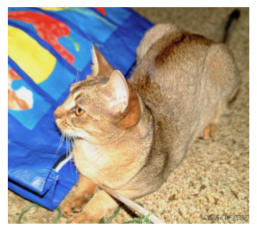

time: 718 ms (started: 2021-07-31 22:19:21 +08:00)


In [6]:
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import load_img, img_to_array

plt.axis("off")

plt.imshow(load_img(input_img_paths[9]))

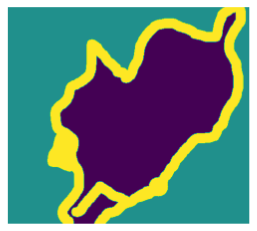

time: 197 ms (started: 2021-07-31 22:19:24 +08:00)


In [7]:
def display_target(target_array):
#     原始标签是 1、2 和 3。我们减去 1，使标签的范围从 0 到 2，
#     然后乘以 127，使标签变为 0（黑色）、127（灰色）、254（接近白色） .
    normalized_array = (target_array.astype("uint8") - 1) * 127 
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])
    
# 我们使用 color_mode='grayscale' 以便我们加载的图像被视为具有单个颜色通道。
img = img_to_array(load_img(target_paths[9], color_mode="grayscale")) 
display_target(img)

接下来，让我们将输入和目标加载到两个 NumPy 数组中，并将数组拆分为训练集和验证集。 由于数据集非常小，我们可以将所有内容加载到内存中。

In [15]:
import numpy as np
import random

# 我们将所有内容调整为 180x180，就像上一章一样。
img_size = (200, 200) 
# 数据中的样本总数。
num_imgs = len(input_img_paths) 

# 打乱文件路径（它们最初是按品种排序的）。 
# 我们在两个语句中使用相同的种子 (1337) 以确保输入路径和目标路径保持相同的顺序。
random.Random(1337).shuffle(input_img_paths) 
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1  # 减去 1，使我们的标签变为 0、1 和 2。
    return img

# 将 input_imgs float32 数组中的所有图像加载到目标 uint8 数组中（相同顺序）。 
# 输入有 3 个通道（RBG 值），目标有一个通道（包含整数标签）。
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32") 
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])
    
# 预留 1000 个样本进行验证。
num_val_samples = 1000
# 将数据拆分为训练集和验证集。
train_input_imgs = input_imgs[:-num_val_samples] 
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [17]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
#     不要忘记将输入图像重新缩放到 [0-1] 范围。
    x = layers.experimental.preprocessing.Rescaling(1./255)(inputs) 
    
#     请注意我们如何在任何地方使用 padding="same" 以避免边框填充对特征图大小的影响。
    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x) 
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    
#     我们以每像素三向 softmax 结束模型，将每个输出像素分类为我们的 3 个类别之一。
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)
    
    outputs = layers.Conv2D(3, num_classes, activation="softmax", padding="same")(x) 
    
    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 128)       147584    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 256)       295168

In [18]:
from tensorflow.keras.utils import plot_model

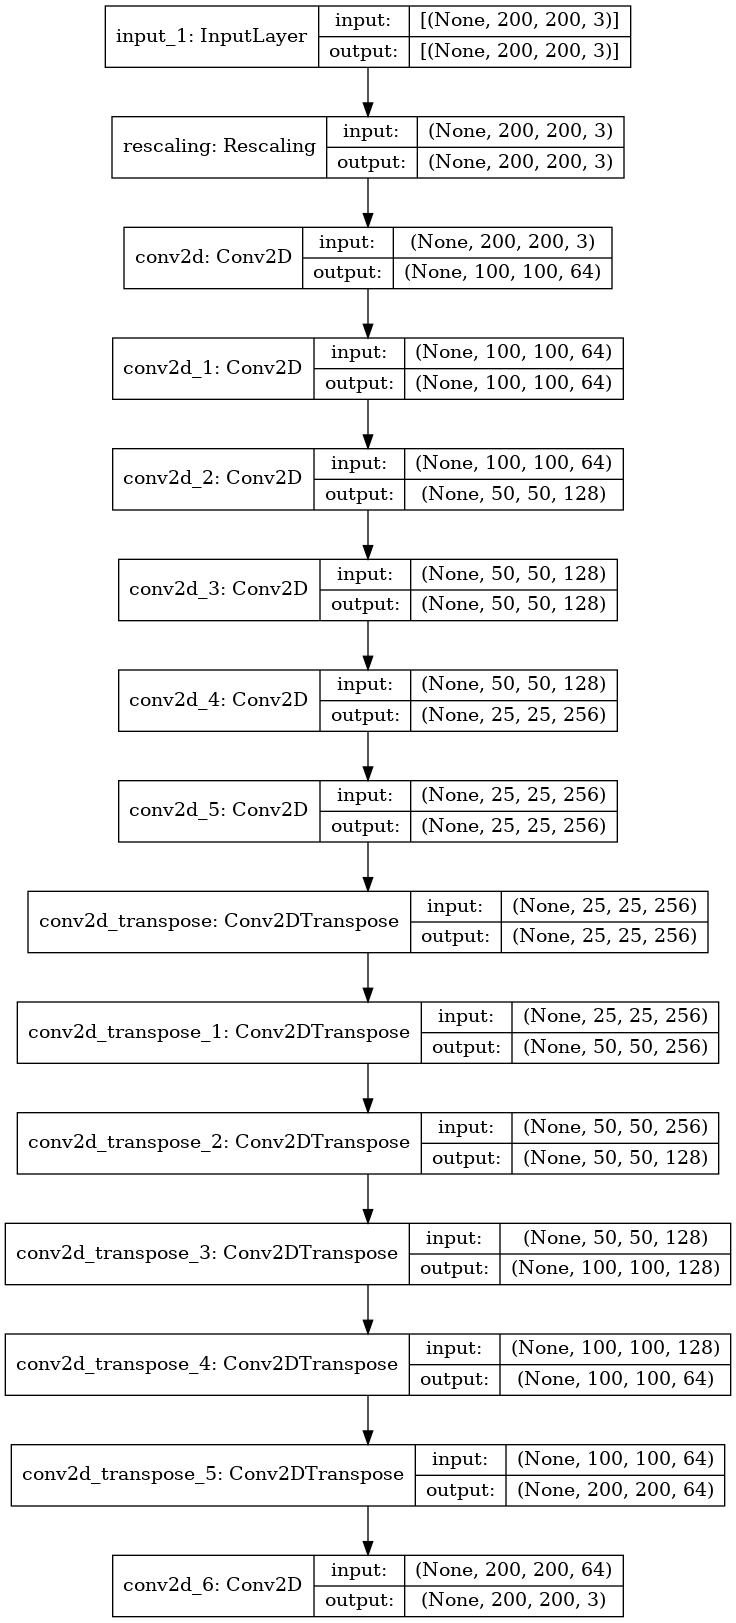

In [20]:
plot_model(model, show_shapes=True)

该模型的前半部分非常类似于您用于图像分类的那种卷积网络：一堆层，过滤器大小逐渐增加。 我们对 Conv2D 的图像进行三次降采样，每次降采样 2 倍——最终激活大小为 (25, 25, 256)。 前半部分的目的是将图像编码为较小的特征图，其中每个空间位置（或“像素”）包含有关原始图像的大空间块的信息。 你可以把它理解为一种压缩。

这个模型的前半部分与您之前看到的分类模型之间的重要区别在于我们进行下采样的方式：在上一章的分类卷积网络中，我们使用 MaxPooling2D 层对特征图进行下采样。在这里，我们通过向每个其他卷积层添加步幅来进行下采样（如果您不记得卷积步幅如何工作的细节，请参阅第 8 章中的“理解卷积步幅”）。我们这样做是因为，在图像分割的情况下，我们非常关心图像中信息的空间位置——因为我们需要生成每像素目标掩码作为模型的输出。当您进行 2x2 最大池化时，您将完全破坏每个池化窗口内的位置信息：您为每个窗口返回一个标量值，而对于该值来自窗口中的 4 个位置中的哪个位置的知识为零。因此，虽然最大池化层在分类任务中表现良好，但对于分割任务来说，它们会对我们造成很大伤害。同时，跨步卷积在保留位置信息的同时，在对特征图进行下采样方面做得更好。在整本书中，你会注意到我们倾向于在任何关心特征位置的模型中使用步幅而不是最大池化——例如第 12 章中的生成模型。

模型的后半部分是一堆 Conv2DTranspose 层。那些是什么？好吧，模型前半部分的输出是形状为 (25, 25, 256) 的特征图，但是我们希望我们最终的输出与目标掩码具有相同的形状，也就是说， (200, 200 , 3)。因此，我们需要应用我们迄今为止应用的一种转换，反转特征映射而不是对它们进行下采样。这就是 Conv2DTranspose 层的上采样目的：您可以将其视为一种学习上采样的卷积层。如果你有一个形状为 (100, 100, 64) 的输入，并且你通过 Conv2D(128, 3, strides=2, padding="same") 层运行它，你会得到一个形状为 (50, 50, 128)。如果通过 Conv2DTranspose(64, 3, strides=2, padding="same") 层运行此输出，您将返回形状为 (100, 100, 64) 的输出，与原始输出相同。因此，在通过一堆 Conv2D 层将我们的输入压缩成形状为 (25, 25, 256) 的特征图之后，我们可以简单地应用相应的 Conv2DTranspose 层序列来返回形状为 (200, 200, 3) 的图像。

我们现在可以编译并拟合我们的模型：

In [21]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",save_best_only=True)]

history = model.fit(train_input_imgs, 
                    train_targets,
                    epochs=50,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/50
100/100 [==============================] - 68s 425ms/step - loss: 1.7289 - val_loss: 0.9791
Epoch 2/50
100/100 [==============================] - 35s 345ms/step - loss: 0.8789 - val_loss: 0.7945
Epoch 3/50
100/100 [==============================] - 29s 294ms/step - loss: 0.7955 - val_loss: 0.7552
Epoch 4/50
100/100 [==============================] - 27s 268ms/step - loss: 0.7716 - val_loss: 0.7145
Epoch 5/50
100/100 [==============================] - 25s 247ms/step - loss: 0.7434 - val_loss: 0.6857
Epoch 6/50
100/100 [==============================] - 23s 229ms/step - loss: 0.6946 - val_loss: 0.6894
Epoch 7/50
100/100 [==============================] - 21s 209ms/step - loss: 0.6533 - val_loss: 0.6550
Epoch 8/50
100/100 [==============================] - 19s 188ms/step - loss: 0.6163 - val_loss: 0.6816
Epoch 9/50
100/100 [==============================] - 19s 189ms/step - loss: 0.6014 - val_loss: 0.7340
Epoch 10/50
100/100 [==============================] - 19s 191ms/step - l

让我们展示我们的训练和验证损失：

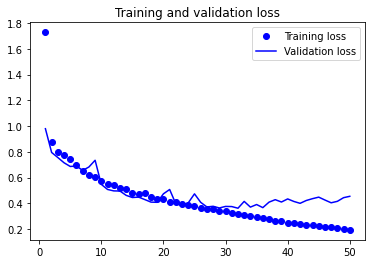

In [22]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

你可以看到我们在中途开始过度拟合，大约在 epoch 25。让我们根据验证精度重新加载我们性能最好的模型，并演示如何使用它来预测分割掩码。

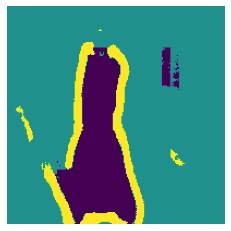

In [23]:
from tensorflow.keras.preprocessing.image import array_to_img

model = keras.models.load_model("oxford_segmentation.keras")

i = 4
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

mask = model.predict(np.expand_dims(test_image, 0))[0]

# 显示模型预测的实用程序。
def display_mask(pred): 
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)
    
display_mask(mask)

我们预测的蒙版中有几个小伪影，是由前景和背景中的几何形状引起的。 尽管如此，我们的模型似乎运行良好。

至此，在第 8 章和第 9 章开头，您已经学习了如何进行图像分类和图像分割的基础知识：您已经可以用您所知道的来完成很多工作。 然而，经验丰富的工程师为解决实际问题而开发的 convnets 并不像我们迄今为止在演示中使用的那么简单。 您仍然缺乏必要的心理模型和思维过程，使专家能够快速准确地决定如何组合最先进的模型。 为了弥补这一差距，您需要了解架构模式。 让我们深入了解。

## 现代 convnet 架构模式

模型的“架构”是创建它的所有选择的总和：使用哪些层、如何配置它们、以何种方式连接它们。 这些选择定义了模型的假设空间：梯度下降可以搜索的可能函数的空间，由模型的权重参数化。 与特征工程一样，一个好的假设空间会编码您手头问题及其解决方案的先验知识。 例如，使用卷积层意味着您事先知道输入图像中存在的相关模式是平移不变的。 为了有效地从数据中学习，你需要对你正在寻找的东西做出假设。

模型架构通常是成功与失败之间的区别。 如果您做出不适当的架构选择，您的模型可能会陷入次优指标，而且再多的训练数据也无法挽救它。 相反，良好的模型架构将加速学习并使您的模型能够有效利用可用的训练数据，从而减少对大型数据集的需求。 一个好的模型架构可以减少搜索空间的大小，或者更容易收敛到搜索空间的一个好的点。 就像特征工程和数据管理一样，模型架构就是让梯度下降更容易解决问题——并且记住梯度下降是一个非常愚蠢的搜索过程，所以它需要它可以获得的所有帮助。

模型架构与其说是一门科学，不如说是一门艺术。 经验丰富的机器学习工程师能够在第一次尝试时凭直觉拼凑出高性能模型，而初学者通常很难创建一个完全可以训练的模型。 这里的关键词是：没有人能凭直觉给你一个清晰的解释，什么有效，什么无效。 专家依赖模式匹配，这是他们通过丰富的实践经验获得的能力。 您将在本书中发展自己的直觉。 然而，这也与直觉无关——实际科学的方式并不多，但就像在任何工程学科中一样，有最佳实践。

在接下来的部分中，我们将回顾一些基本的 convnet 架构最佳实践，特别是残差连接、批量归一化和可分离卷积。 一旦掌握了如何使用它们，您将能够构建高效的图像模型。 我们将演示如何将它们应用于我们的猫与狗分类问题。

让我们从鸟瞰开始：系统架构的模块化-层次-重用（MHR）公式。

### 模块化、层次结构和重用

如果你想让一个复杂的系统更简单，你可以应用一个通用的方法：只需将复杂的无定形汤结构化为 ，将模块组织成模块层次结构重用 ，并在适当的多个位置启动相同的模块（“重用” 是另一个词）。 这就是 MHR 公式（模块化-层次结构-重用），它的抽象是几乎所有使用“架构”一词的领域的系统架构的基础。 它是任何有意义的复杂系统的组织的核心，无论是大教堂、您自己的身体、美国海军还是 Keras 代码库。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gszy6y0io2j30zg0ta7e8.jpg)

如果您是一名软件工程师，您已经非常熟悉这些原则：有效的代码库是模块化的、分层的，并且您不会两次重新实现同一件事，而是依赖于可重用的类和函数。 如果你遵循这些原则来考虑你的代码，你可以说你在做“软件架构”。

深度学习本身只是将这个配方应用到通过梯度下降进行连续优化：您采用经典的优化技术（连续函数空间上的梯度下降），并将搜索空间构建为模块（层），组织成一个深层层次结构 （通常只是一个堆栈，最简单的层次结构），您可以在其中重用任何可能的东西（例如，卷积都是关于在不同的空间位置重用相同的信息）。

同样，深度学习模型架构主要是巧妙地利用模块化、层次结构和重用。 您会注意到，所有流行的 convnet 架构不仅结构化为层，而且结构化为重复的层组（称为“块”或“模块”）。 例如，我们在上一章中使用的流行 VGG16 架构被构造成重复的“conv - conv - max pooling”块（见图 9.8）。

此外，大多数 convnets 通常具有金字塔状结构（特征层次结构）。 回想一下，例如，我们在上一章构建的第一个卷积网络中使用的卷积过滤器数量的变化：32、64、128。过滤器的数量随着层深度的增加而增加，而特征图的大小相应地缩小 . 您会在 VGG16 模型的块中注意到相同的模式（见图 9.8）。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gszy9y6dmbj318e0qadje.jpg)

更深的层次结构本质上是好的，因为它们鼓励特征重用，因此也鼓励抽象。 一般来说，窄层的深堆叠比大层的浅堆叠性能更好。 但是，堆叠层的深度是有限制的：梯度消失的问题。 这将我们引向我们的第一个基本模型架构模式：残差连接。

> **论消融研究在深度学习研究中的重要性**  
> 深度学习架构通常不仅仅是设计出来的——它们是通过反复尝试和选择似乎有效的方法而发展起来的。 就像在生物系统中一样，如果您采用任何复杂的实验性深度学习设置，您很可能可以在不损失性能的情况下删除一些模块（或用随机模块替换一些经过训练的功能）。  
>
> 深度学习研究人员面临的激励使情况变得更糟：通过使系统变得比必要的复杂，他们可以使它看起来更有趣或更新颖，从而增加他们通过同行评审过程获得论文的机会。 如果您阅读了大量深度学习论文，您会注意到它们通常在风格和内容上针对同行评审进行了优化，这些方式会积极损害解释的清晰度和结果的可靠性。 例如，深度学习论文中的数学很少用于明确形式化概念或推导出不明显的结果——相反，它被用作严肃的信号，就像推销员穿着昂贵的西装一样。
>
> 研究的目标不应该仅仅是发表，而是产生可靠的知识，理解因果关系。 至关重要的是，在您的系统中是生成可靠知识的最直接方式。 研究因果关系有一种非常省力的方法：消融研究。 消融研究包括系统地尝试移除系统的某些部分——使其更简单——以确定其性能的实际来源。 如果你发现 X + Y + Z 给你很好的结果，也试试 X、Y、Z、X + Y、X + Z、Y + Z，看看会发生什么。
>
> 如果您成为一名深度学习研究人员，请消除研究过程中的噪音：对您的模型进行消融研究。 总是问：“能不能有一个更简单的解释？这种增加的复杂性真的有必要吗？为什么？”

### 残差连接

您可能知道电话游戏，在英国也称为中国耳语，在法国也称为 téléphone arabe，在这种游戏中，最初的信息在玩家耳边耳语，然后在下一位玩家耳边耳语，等等 . 最终的消息最终与其原始版本几乎没有相似之处。 这是一个有趣的比喻，用于在嘈杂的信道上顺序传输中发生的累积错误。

碰巧的是，顺序深度学习模型中的反向传播与电话游戏非常相似。 您有一系列函数，如下所示：
```
y = f4(f3(f2(f1(x))))
```

游戏的名称是根据f4的输出记录的错误（模型的损失）调整每个函数的参数。 要调整 f1，您需要通过 f2、f3 和 f4 渗透误差信息。 但是，链中的每个连续函数都会在此过程中引入一些噪声。 如果你的函数链太深，这种噪音就会开始淹没梯度信息，反向传播就会停止工作。 你的模型根本不会训练。 这称为梯度消失问题。

修复方法很简单：只需强制链中的每个函数都是非破坏性的——保留包含在先前输入中的信息的无噪声版本。 实现这一点的最简单方法称为残差连接。 这很简单：只需将一个层或层块的输入添加回其输出（见图 9.9）。 残差连接充当破坏性或嘈杂块（例如包含 ReLU 激活或
dropout 层），使来自早期层的误差梯度信息能够通过深层网络无噪声地传播。 该技术于 2015 年与 ResNet 系列模型（由 He 等人在 Microsoft 开发）一起引入。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gszyn03bnoj30va0mmwf8.jpg)

在实践中，你会实现一个像这样的残差连接：
``` Python
# 一些输入张量。
x = ... 
# 保存指向原始输入的指针。 这被称为“残差”。
residual = x 
# 这个计算块可能是破坏性的或嘈杂的，这很好。
x = block(x) 
# 将原始输入添加到层的输出：因此最终输出将始终保留有关原始输入的完整信息。
x = add([x, residual])
```

请注意，将输入添加回块的输出意味着输出应与输入具有相同的形状。 请注意，如果您的块包含具有更多过滤器或最大池化层的卷积层，则情况并非如此。 在这种情况下，使用没有激活的 1x1 Conv2D 层将残差线性投影到所需的输出形状。 您通常会在目标块的卷积层中使用 padding="same" 以避免由于填充导致的空间下采样，并且您会在残差投影中使用步幅来匹配由最大池化层引起的任何下采样。

> 清单 9.2 目标块改变输出过滤器数量的情况

In [5]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)

# 把残差放在一边。
residual = x 

# 这是我们在其周围创建残差连接的层：它将输出过滤器的数量从 32 增加到 64。
# 请注意，我们使用 padding="same" 以避免由于填充而下采样。
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x) 

# 残差只有 32 个过滤器，因此我们使用 1x1 将其投影到正确的 Conv2D 形状。
residual = layers.Conv2D(64, 1)(residual) 

# 现在块输出和残差具有相同的形状并且可以添加。
x = layers.add([x, residual])

model = keras.Model(inputs= inputs, outputs=x)

time: 1.79 s (started: 2021-07-31 19:04:41 +08:00)


In [29]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 30, 30, 32)   896         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 30, 30, 64)   18496       conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 30, 30, 64)   2112        conv2d_16[0][0]                  
____________________________________________________________________________________________

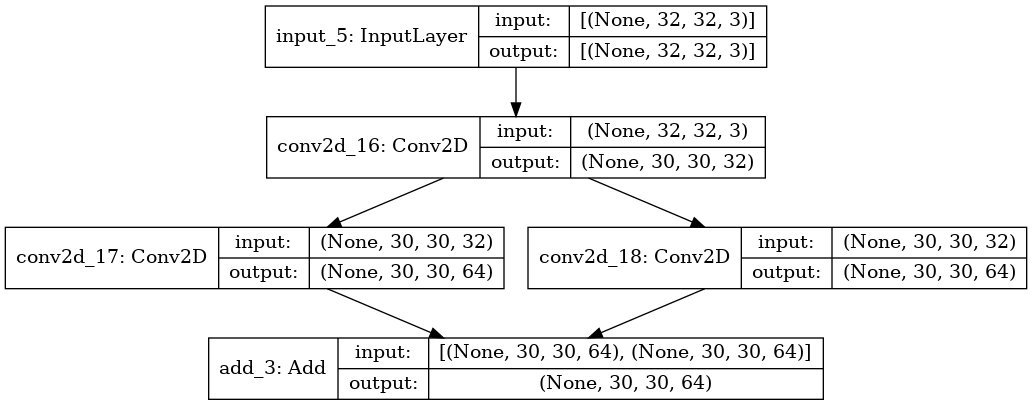

In [31]:
plot_model(model, show_shapes=True)

> 清单 9.3 目标块包含最大池化层的情况

In [32]:
inputs = keras.Input(shape=(32, 32, 3))

x = layers.Conv2D(32, 3, activation="relu")(inputs)

# 把残差放在一边。
residual = x 

# 这是我们在其周围创建残差连接的两层块：它包括一个 2x2 最大池化层。 
# 请注意，我们在卷积层和最大池化层中都使用 padding="same" 以避免由于填充而下采样。
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x) 
x = layers.MaxPooling2D(2, padding="same")(x) 

# 我们在残差投影中使用最大池化层匹配下采样创建的strides=2。
residual = layers.Conv2D(64, 1, strides=2)(residual) 

# 现在块输出和残差具有相同的形状并且可以添加。
x = layers.add([x, residual])

model = keras.Model(inputs= inputs, outputs=x)

In [33]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 30, 30, 32)   896         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 30, 30, 64)   18496       conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 15, 15, 64)   0           conv2d_20[0][0]                  
____________________________________________________________________________________________

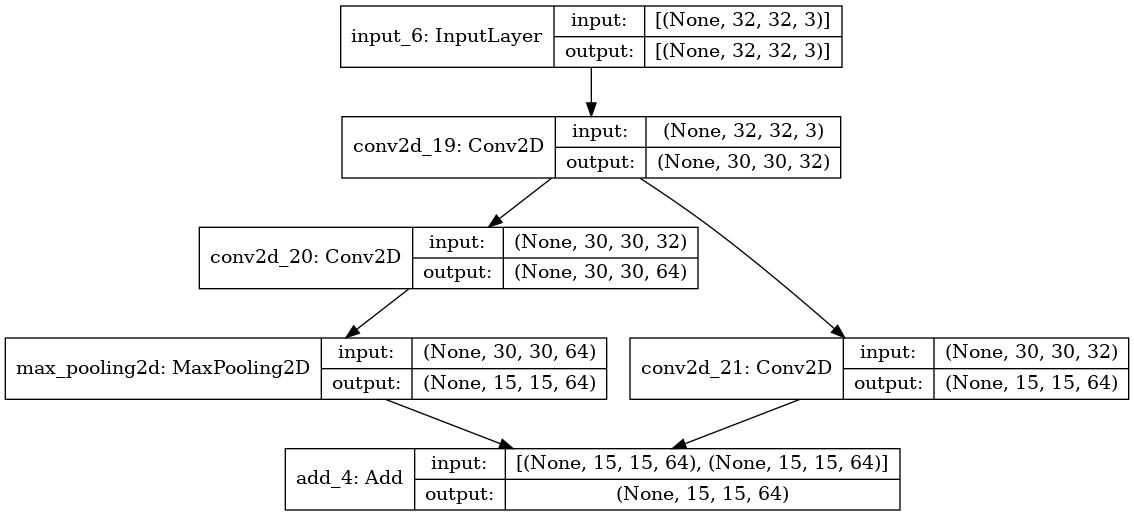

In [34]:
plot_model(model, show_shapes=True)

为了使这些想法更具体，这里有一个简单的卷积网络示例，它由一系列块组成，每个块由两个卷积层和一个可选的最大池化层组成，每个块周围都有一个残差连接：

In [35]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 应用具有残差连接的卷积块的实用函数，可以选择添加最大池化。
def residual_block(x, filters, pooling=False): 
    
    residual = x
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    
    if pooling:
        x = layers.MaxPooling2D(2, padding="same")(x)
#         如果我们使用最大池化，我们会添加一个跨步卷积来将残差投影到预期的形状。
        residual = layers.Conv2D(filters, 1, strides=2)(residual) 
    elif filters != residual.shape[-1]:
#         如果我们不使用最大池化，我们只会在通道数量发生变化时投影残差。
        residual = layers.Conv2D(filters, 1)(residual) 
    
    x = layers.add([x, residual])
    return x

# 第一个块。
x = residual_block(x, filters=32, pooling=True) 
# 第二块。 注意每个块中增加的过滤器计数。
x = residual_block(x, filters=64, pooling=True) 
# 最后一个块不需要最大池化层，因为我们将在它之后立即应用全局平均池化。
x = residual_block(x, filters=128, pooling=False) 

x = layers.GlobalAveragePooling2D()(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 32, 32, 3)    0           input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 32, 32, 32)   896         rescaling_1[0][0]                
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 32, 32, 32)   9248        conv2d_22[0][0]                  
____________________________________________________________________________________________

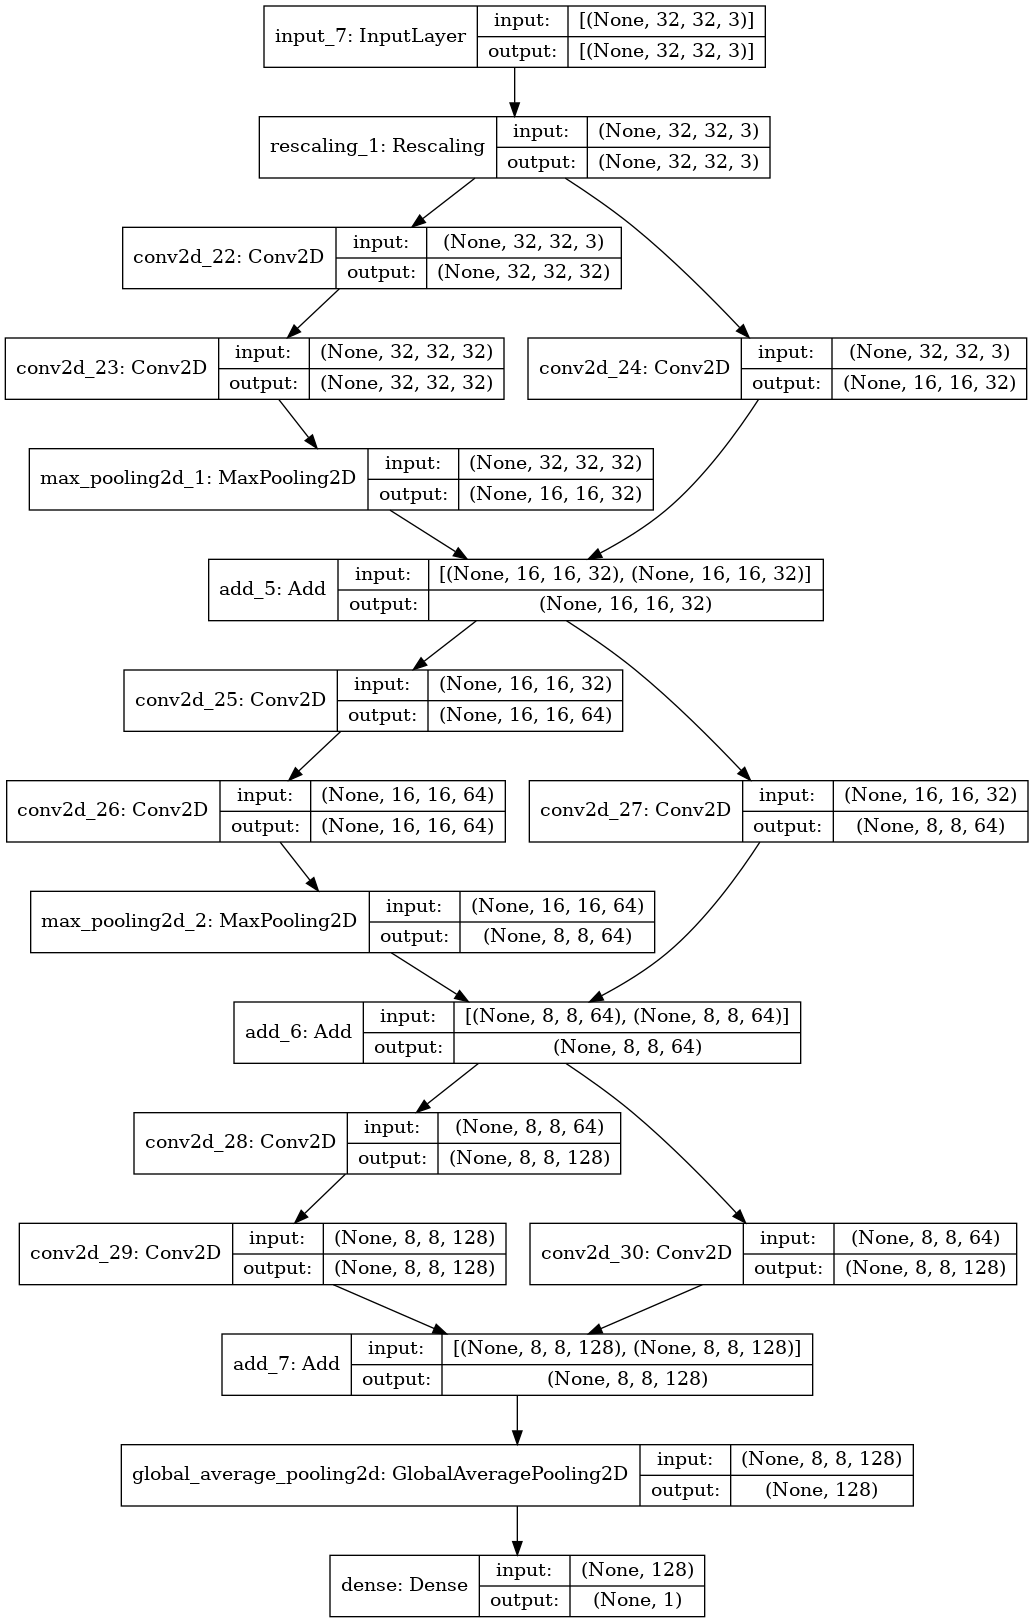

In [36]:
plot_model(model, show_shapes=True)

使用残差连接，您可以构建任意深度的网络，而不必担心梯度消失。 现在，让我们继续下一个基本的 convnet 架构模式：批量归一化。

### 批量归一化

归一化是一大类方法，旨在使机器学习模型看到的不同样本彼此更加相似，这有助于模型学习并很好地推广到新数据。 最常见的数据归一化形式是您在本书中已经见过多次的形式：通过从数据中减去均值使数据以零为中心，并通过将数据除以其标准偏差来给数据一个单位标准偏差。 实际上，这假设数据遵循正态（或高斯）分布，并确保该分布居中并缩放到单位方差：
```
normalized_data = (data - np.mean(data, axis=...)) / np.std(data, axis=...)
```

您在本书中看到的先前示例在将数据输入模型之前对数据进行了标准化。 但是在网络操作的每次转换之后，数据规范化可能是一个问题：即使进入 Dense 或 Conv2D 网络的数据具有 0 均值和单位方差，也没有理由期望先验数据会出现这种情况 出去。 标准化中间激活有帮助吗？

批量标准化就是这样做的。 它是 Ioffe 和 Szegedy 于 2015 年引入的一种层类型（Keras 中的 BatchNormalization）； 即使在训练期间均值和方差随时间变化，它也可以自适应地归一化数据。 在训练期间，它使用当前批次数据的均值和方差对样本进行归一化，在推理期间（当可能没有足够大的代表性数据批次时），它使用批量均值的指数移动平均值和 训练期间看到的数据的方差。

尽管最初的论文强调批标准化是通过“减少内部协变量偏移”来运行的，但没有人真正知道为什么批标准化有帮助。 有各种各样的假设，但没有确定性。 您会发现深度学习中的许多事情都是如此——深度学习不是一门精确的科学，而是一组不断变化的、凭经验得出的工程最佳实践，由不可靠的叙述编织在一起。 有时你会觉得你手头的书告诉你做某事，但并没有完全令人满意地说它有效：为什么会这样，因为我们知道如何做，但我们不知道为什么。 每当有可靠的解释可用时，我一定会提及它。 批量标准化不是这些情况之一。

在实践中，批量归一化的主要效果似乎是它有助于梯度传播——很像残差连接——从而允许更深的网络。 一些非常深的网络只有在包含多个 BatchNormalization 层时才能进行训练。 例如，批量归一化在许多与 Keras 一起打包的高级 convnet 架构中被广泛使用，例如 ResNet50、EfficientNet 和 Xception。

BatchNormalization 层可以在任何层之后使用——Dense,Conv2D 等：
```Python
x = ...
# 因为层的输出被归一化，所以层不需要它自己的 Conv2D 偏置向量。
x = layers.Conv2D(32, 3, use_bias=False)(x) 
x = layers.BatchNormalization()(x)
```

> Dense 和 Conv2D 都涉及“偏置向量”，这是一个学习变量，其目的是使层仿射而不是纯线性。 例如，Conv2D 返回，示意性地， y = conv(x, kernel) + bias ，而 Dense 返回 y = dot(x, kernel) + bias。 由于归一化步骤将负责将层的输出集中在零上，因此在使用 BatchNormalization 时不再需要偏置向量，并且可以通过选项 use_bias=False 在没有它的情况下创建层。 这使图层稍微更精简。

重要的是，我通常建议将前一层的激活放在标准化层之后的批次（尽管这仍然是一个有争议的话题）。 所以，而不是做：

> 清单 9.4 如何不使用批量标准化

In [ ]:
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.BatchNormalization()(x)

你实际上会这样做：

> 清单 9.5 如何使用批量归一化：最后激活

In [ ]:
x = layers.Conv2D(32, 3, use_bias=False)(x) #注意这里没有激活。
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x) #我们将激活放在 BatchNormalization 层之后。

直观的原因是批量归一化将使您的输入以零为中心，而您的 ReLU 激活使用零作为保持或删除激活通道的支点：在激活之前进行归一化可以最大限度地利用 ReLU。 也就是说，这种排序最佳实践并不完全重要，因此如果您进行“卷积 - 激活 - 批量标准化”，您的模型仍然会训练，并且您不一定会看到更糟糕的结果。

> **关于批量归一化和微调**  
> 批量标准化有许多怪癖。 其中一个主要涉及微调：在微调包含 BatchNormalization 层的模型时，我建议让这些层保持冻结状态（将它们的属性设置为可训练的 False）。 否则，它们将不断更新其内部均值和方差，这会干扰应用于周围 Conv2D 层的非常小的更新。

现在，让我们来看看我们系列中的最后一个架构模式：深度可分离卷积。

### 深度可分离卷积

如果我告诉您有一个层可以用作 Conv2D 的直接替代品，那将使您的模型更小（可训练的权重参数更少）、更精简（浮点运算更少），并使其执行一些 它的任务好几个百分点？ 这正是深度可分离卷积层所做的（Keras 中的 SeparableConv2D）。 该层在其输入的每个通道上独立执行空间卷积，然后通过逐点卷积（1×1 卷积）混合输出通道，如图 9.10 所示。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gt01ozj4uwj31a00pg76p.jpg)

这相当于将空间特征的学习和通道特征的学习分开。 与卷积依赖于图像中的模式不依赖于特定位置的假设大致相同，深度可分离卷积依赖于中间激活中的空间位置与不同通道高度相关但高度独立的假设。 因为这个假设对于深度神经网络学习的图像表示通常是正确的，所以它可以作为一个有用的先验，帮助模型更有效地利用其训练数据。 一个关于它必须处理的信息结构具有更强先验的模型是一个更好的模型——只要先验是准确的。

与常规卷积相比，深度可分离卷积需要更少的参数和更少的计算，同时具有可比的表示能力。 它们导致较小的模型收敛更快并且不太容易过度拟合。 当您在有限的数据上从头开始训练小型模型时，这些优势变得尤为重要。

对于更大规模的模型，深度可分离卷积是 Xception 架构的基础，这是一种与 Keras 打包在一起的高性能卷积网络。 您可以在论文“Xception: Deep Learning with Depthwise Separable Convolutions”中阅读更多关于深度可分离卷积和 Xception 的理论基础。

> **硬件、软件和算法的共同进化**   
> 考虑具有 3x3 窗口、64 个输入通道和 64 个输出通道的常规卷积操作。 它使用 3\*3\*64\*64 = 36,864 个可训练参数，当您将其应用于图像时，它会运行许多与此参数计数成正比的浮点运算。 同时，考虑一个等效的深度可分离卷积：它只涉及 3\*3\*64 + 64*64 = 4,672 个可训练参数，并且按比例减少浮点运算。 这种效率提升只会随着过滤器的数量或卷积窗口的大小变大而增加。 
>
>因此，您会期望深度可分离卷积为快得多，对吧？ 稍等。 如果您正在编写这些算法的简单 CUDA 或 C 实现，这将是正确的——事实上，在 CPU 上运行时，您确实看到了有意义的加速，其中底层实现是并行化的 C 。 但在实践中，您可能正在使用 GPU，并且您在其上执行的操作远非“简单”的 CUDA 实现：它是一个 cuDNN 内核，一段经过特别优化的代码，直到每条机器指令 . 花费大量精力优化此代码当然是有意义的，因为 NVIDIA 硬件上的 cuDNN 卷积每天负责许多 exaFLOPS 的计算。 但这种极端微观优化的副作用是替代方法几乎没有机会在性能上竞争——即使是具有显着内在优势的方法，如深度可分离卷积。
>
>尽管一再向 NVIDIA 提出要求，但深度可分离卷积并没有从与常规卷积几乎相同级别的软件和硬件优化中受益，因此它们的速度与常规卷积一样快，即使它们使用的参数和 浮点运算。 但是请注意，即使不会导致加速，使用深度可分离卷积仍然是一个好主意：它们较低的参数数量意味着您过拟合的风险较小，并且它们假设通道应该不相关会导致更快的模型收敛 和更健壮的表示。
>
>在这种情况下的轻微不便在其他情况下可能会成为不可逾越的墙：因为深度学习的整个硬件和软件生态系统已经针对一组非常特定的算法（特别是通过反向传播训练的卷积网络）进行了微优化，所以有一个 偏离常规路线的成本极高。 如果您要尝试替代算法，例如无梯度优化或尖峰神经网络，那么您提出的前几个并行 C++ 或 CUDA 实现将比旧的 convnet 慢几个数量级——无论多么聪明 你的想法很有效。 说服其他研究人员采用你的方法将是一个艰难的卖点，即使它只是更好。
>
>你可以说现代深度学习是硬件、软件和算法之间共同进化过程的产物：NVIDIA GPU 和 CUDA 的可用性导致了反向传播训练的 convnets 的早期成功，这导致 NVIDIA 优化其硬件和 这些算法的软件，这反过来又导致了这些方法背后的研究社区的整合。 在这一点上，找出不同的路径需要对整个生态系统进行多年的重新设计。

### 组合起来：一个类似 Xception 的迷你模型

提醒一下，以下是您迄今为止学到的 convnet 架构原则：
* 你的模型应该被组织成重复的层块，通常由多个卷积层和一个最大池化层组成。
* 随着空间特征图的大小减小，图层中的过滤器数量应该增加。
* 深而窄胜于宽而浅。
* 在层块周围引入残差连接可帮助您训练更深的网络。
* 在卷积层之后引入批量归一化层是有益的。
* 用参数效率更高的 SeparableConv2D 层替换 Conv2D 层是有益的。

让我们将这些想法整合到一个模型中。 它的架构类似于 Xception 的较小版本。 我们将把它应用到上一章的狗与猫任务中。 对于数据加载和模型训练，只需重复使用与我们在第 9 章“使用数据增强”部分中使用的完全相同的设置——但将模型定义替换为以下卷积网络：

In [6]:
data_augmentation = keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal"),
                                      layers.experimental.preprocessing.RandomRotation(0.1),
                                      layers.experimental.preprocessing.RandomZoom(0.2),
                                     ])

time: 291 ms (started: 2021-07-31 19:05:02 +08:00)


In [7]:
inputs = keras.Input(shape=(180, 180, 3))
# 我们使用与以前相同的数据增强配置。
x = data_augmentation(inputs) 

# 不要忘记输入重新缩放！
x = layers.experimental.preprocessing.Rescaling(1./255)(x) 

# 请注意，作为可分离卷积基础的假设，“特征通道在很大程度上是独立的”，
# 不适用于 RGB 图像！ 红、绿、蓝颜色通道在自然图像中实际上高度相关。 
# 因此，我们模型中的第一层是常规的 Conv2D 层。 之后我们将开始使用 SeparableConv2D。
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x) 

# 我们应用一系列具有增加特征深度的卷积块。 
# 每个块由两个批量归一化的深度可分离卷积层和一个最大池化层组成，整个块周围有一个残差连接。
for size in [32, 64, 128, 256, 512]: 
    residual = x
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])
    
# 在原始模型中，我们在层之前使用了一层。 在这里，我们使用 GlobalAveragePooling2D 层对 Dense 进行扁平化处理。
x = layers.GlobalAveragePooling2D()(x) 
# 就像在原始模型中一样，我们添加了一个用于正则化的 dropout 层。
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

time: 833 ms (started: 2021-07-31 19:05:08 +08:00)


In [8]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 180, 180, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 180, 180, 3)  0           sequential[0][0]                 
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 176, 176, 32) 2400        rescaling[0][0]                  
____________________________________________________________________________________________

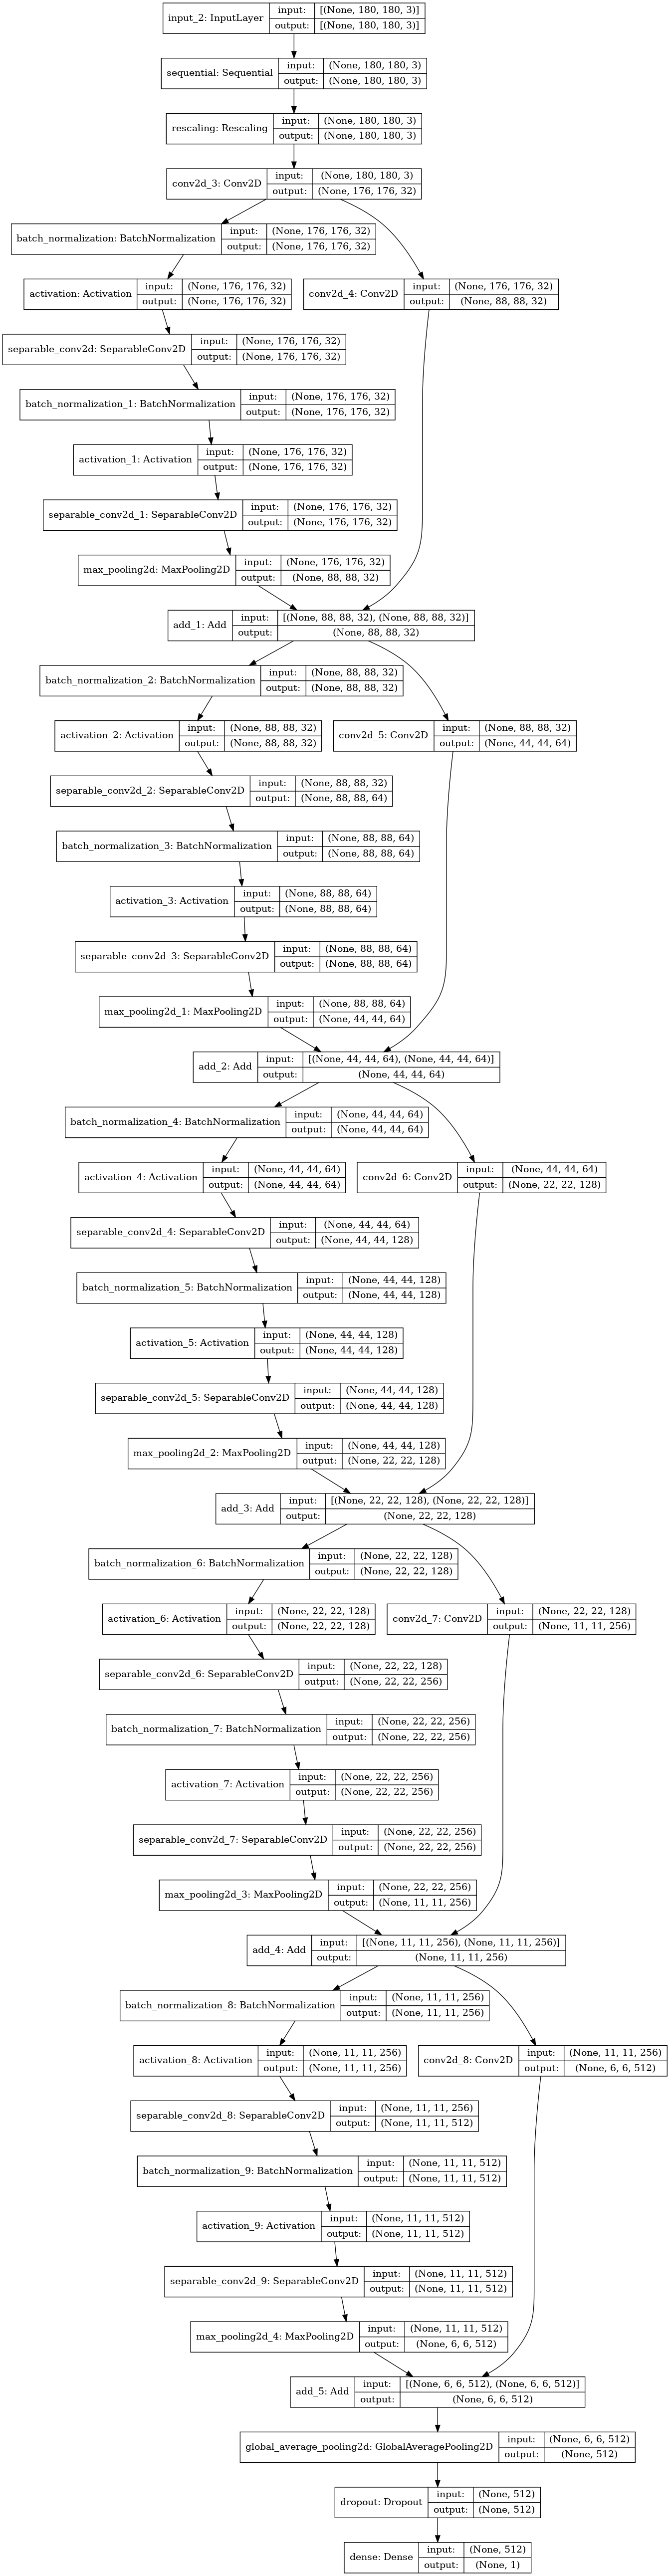

time: 1.24 s (started: 2021-07-31 19:05:41 +08:00)


In [10]:
from tensorflow.keras.utils import plot_model

plot_model(model,show_shapes=True)

这个 convnet 的可训练参数数为 721,857，略低于原始模型的 991,041 可训练参数，但仍处于相同的范围内。 这是它的训练和验证曲线：

![](https://tva1.sinaimg.cn/large/008i3skNgy1gt03e5iyp5j317y0gy421.jpg)

你会发现我们的新模型达到了 90.8% 的测试准确率——而上一章的朴素模型的准确率是 83.5%。 如您所见，遵循架构最佳实践确实会对模型性能产生直接的、相当大的影响！

此时，如果你想进一步提高性能，你应该开始系统地调整你的架构的超参数——我们在第 13 章详细讨论这个主题。我们这里没有经过这一步，所以模型的配置 以上完全来自我们概述的最佳实践，此外，在衡量模型大小时，还有一些直觉。

请注意，这些架构最佳实践通常与计算机视觉相关，而不仅仅是图像分类。 例如，Xception 在 DeepLabV3 中用作标准卷积基础，这是一种流行的最先进的图像分割解决方案。

我们对基本 convnet 架构最佳实践的介绍到此结束。 掌握了这些原则，您将能够在各种计算机视觉任务中开发性能更高的模型。 你现在正在成为一名熟练的计算机视觉从业者的路上。 为了进一步加深您的专业知识，我们需要讨论最后一个重要主题：解释模型如何得出其预测。

## 解释卷积神经网络学到的东西

构建计算机视觉应用程序时的一个基本问题是可解释性：为什么您的分类器认为特定图像包含冰箱，而您只能看到一辆卡车？这与深度学习用于补充人类专业知识的用例尤其相关，例如医学成像用例。我们将通过让您熟悉一系列不同的技术来结束本章，这些技术用于可视化 convnet 学习的内容和理解它们所做的决策。

人们常说深度学习模型是“黑匣子”：它们学习难以提取并以人类可读形式呈现的表征。尽管这对于某些类型的深度学习模型部分正确，但对于 convnets 绝对不是这样。 convnets 学习到的表示非常适合可视化，这在很大程度上是因为它们是视觉概念的表示。自 2013 年以来，已经开发了多种技术来可视化和解释这些表示。我们不会调查所有这些，但我们将介绍三个最容易访问和最有用的：
* 可视化中间 convnet 输出（中间激活）——有助于理解连续的 convnet 层如何转换它们的输入，并有助于初步了解单个 convnet 过滤器的含义。
* 可视化 convnets 过滤器 - 有助于准确理解 convnet 中的每个过滤器接受的视觉模式或概念。
* 可视化图像中类激活的热图——有助于理解图像的哪些部分被识别为属于给定的类，从而允许您定位图像中的对象。

对于第一种方法——激活可视化——您将使用在第 8.2 节中针对狗与猫分类问题从头开始训练的小型 convnet。 对于接下来的两种方法，您将使用 TODO 部分中介绍的 VGG16 模型。

### 可视化中间激活

可视化中间激活包括显示模型中各种卷积层和池化层返回的值，给定某个输入（层的输出通常称为它的 ，即激活函数的输出）。 这给出了如何将输入激活分解为网络学习的不同过滤器的视图。 您希望通过三个维度来可视化特征图：宽度、高度和深度（通道）。 每个通道编码相对独立的特征，因此可视化这些特征图的正确方法是将每个通道的内容独立绘制为 2D 图像。 让我们从加载您在第 8.2 节中保存的模型开始：

In [9]:
from tensorflow import keras

model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 43, 43, 64)        0   

接下来，您将获得一个输入图像——一张猫的图片，而不是网络训练图像的一部分。

> 清单 9.6 预处理单个图像

In [15]:
from tensorflow import keras
import numpy as np

img_path = keras.utils.get_file(
    fname="cat.jpg",
    origin="https://img-datasets.s3.amazonaws.com/cat.jpg")

def get_img_array(img_path, target_size):
    
#     打开图像文件并调整其大小。
    img = keras.preprocessing.image.load_img(img_path, target_size=target_size) 
    
#     将图像变成一个 float32 NumPy 形状的数组 (180, 180, 3)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0) 
    return array

img_tensor = get_img_array(img_path, target_size=(180, 180))

time: 58.8 ms (started: 2021-07-31 22:20:20 +08:00)


让我们显示图片（见图 9.12）。

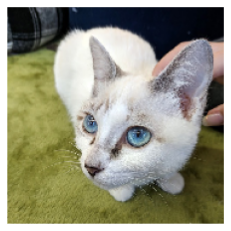

time: 982 ms (started: 2021-07-31 19:31:38 +08:00)


In [9]:
import matplotlib.pyplot as plt

plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

为了提取您想要查看的特征图，您将创建一个 Keras 模型，该模型将批量图像作为输入，并输出所有卷积层和池化层的激活。

In [10]:
from tensorflow.keras import layers

layer_outputs = []
layer_names = []

for layer in model.layers:
#     提取所有 Conv2D 和 MaxPooling2D 层的输出并将它们放在一个列表中
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)): 
        layer_outputs.append(layer.output)
        layer_names.append(layer.name) #同时保存图层名称以备后用
        
# 给定模型输入，创建一个将返回这些输出的模型
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

time: 15.9 ms (started: 2021-07-31 19:31:42 +08:00)


当输入图像时，该模型以列表形式返回原始模型中层激活的值。 这是您在本书中第一次在实践中遇到多输出模型，因为您在第 7 章中了解到它们：到目前为止，您看到的模型只有一个输入和一个输出。 这个有一个输入和九个输出：每层激活一个输出。

In [8]:
activation_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 43, 43, 64)        0     

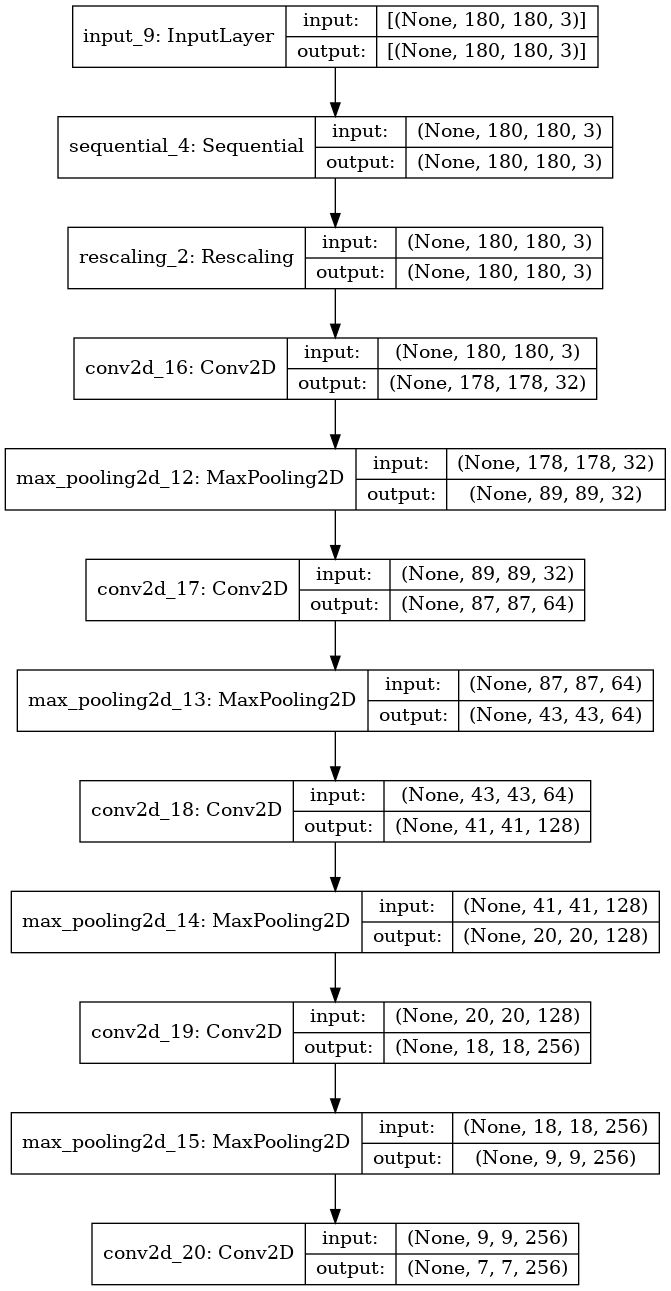

time: 1.66 s (started: 2021-07-31 19:33:27 +08:00)


In [13]:
from tensorflow.keras.utils import plot_model

plot_model(activation_model, show_shapes=True)

In [11]:
# 返回九个 NumPy 数组的列表：每层激活一个数组
activations = activation_model.predict(img_tensor)

time: 12.9 s (started: 2021-07-31 19:31:53 +08:00)


例如，这是猫图像输入的第一个卷积层的激活：

In [14]:
first_layer_activation = activations[1]
print(first_layer_activation.shape)

(1, 89, 89, 32)
time: 767 µs (started: 2021-07-31 19:33:49 +08:00)


这是一个 178 × 178 的特征图，有 32 个通道。 让我们尝试绘制原始模型第一层激活的第四个通道（见图 9.13）。

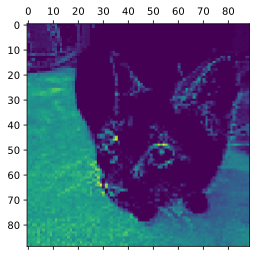

time: 1.11 s (started: 2021-07-31 19:36:37 +08:00)


In [19]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 5], cmap="viridis");

这个通道似乎编码了一个对角边缘检测器——但请注意，您自己的通道可能会有所不同，因为卷积层学习的特定过滤器不是确定性的。 

现在，让我们绘制网络中所有激活的完整可视化图（见图 9.14）。
我们将提取并绘制每个层激活中的每个通道，并将结果堆叠在一个大网格中，通道并排堆叠。

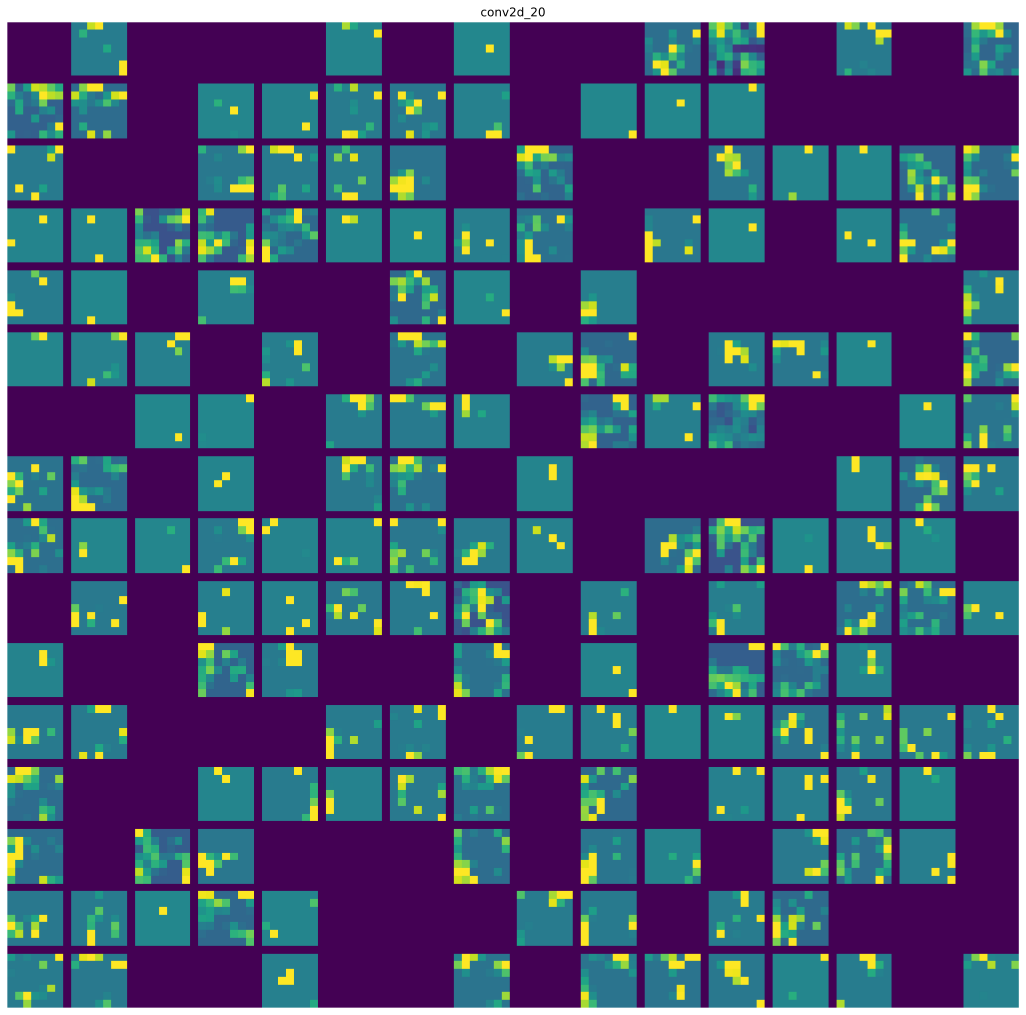

time: 751 ms (started: 2021-07-31 19:53:09 +08:00)


In [21]:
images_per_row = 16

# 迭代激活（以及相应层的名称）
for layer_name, layer_activation in zip(layer_names, activations): 
    
#     层激活具有形状 (1, size, size, n_features)。
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    
#     准备一个空网格来显示此激活中的所有通道。
    display_grid = np.zeros(((size + 1) * n_cols - 1, images_per_row * (size + 1) - 1))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
    #         这是单个通道（或功能）。
            channel_image = layer_activation[0, :, :, channel_index].copy() 
            if channel_image.sum() != 0:
    #             标准化 [0, 255] 范围内的通道值。 全零通道保持为零。
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8") 
            display_grid[
    #             将通道矩阵放置在我们准备好的空网格中。
                col * (size + 1): (col + 1) * size + col,
                row * (size + 1) : (row + 1) * size + row] = channel_image 
            
# 显示图层的网格。
scale = 1. / size
plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
plt.title(layer_name)
plt.grid(False)
plt.axis("off")
plt.imshow(display_grid, aspect="auto", cmap="viridis")

这里有几点需要注意：
* 第一层充当各种边缘检测器的集合。 在那个阶段，激活保留了初始图片中存在的几乎所有信息。
* 随着你走得更高，激活变得越来越抽象，视觉上的解释也越来越少。 他们开始编码更高级的概念，例如“猫耳”和“猫眼”。 更高的呈现携带越来越少的关于图像视觉内容的信息，而越来越多的与图像类别相关的信息。
* 激活的稀疏性随着层的深度增加：在第一层，所有过滤器都被输入图像激活； 但是在接下来的层中，越来越多的过滤器是空白的。 这意味着在输入图像中找不到过滤器编码的模式。

我们刚刚证明了深度神经网络学习的表征的一个重要的普遍特征：随着层的深度，层提取的特征变得越来越抽象。 更高层的激活携带的关于所看到的特定输入的信息越来越少，而关于目标的信息越来越多（在这种情况下，图像的类别：猫或狗）。 深度神经网络有效地充当信息蒸馏管道，原始数据（在这种情况下为 RGB 图片）并被反复转换，以便过滤掉不相关的信息（例如，图像的特定视觉外观），以及 有用的信息被放大和细化（例如，图像的类别）。

这类似于人类和动物感知世界的方式：在观察场景几秒钟后，人类可以记住其中存在哪些抽象物体（自行车、树），但无法记住这些物体的具体外观。 事实上，如果你试图从记忆中画出一辆通用的自行车，即使你一生见过数千辆自行车，你也有可能无法完全正确地画出它（例如，见图 9.15）。 立即尝试：这种效果绝对真实。 你的大脑已经学会完全抽象它的视觉输入——将其转化为高级视觉概念，同时过滤掉不相关的视觉细节——这使得记住周围事物的外观变得非常困难。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gt0ebul6zpj319c0n4423.jpg)

### 可视化 convnet 过滤器

检查 convnets 学习的过滤器的另一种简单方法是显示每个过滤器要响应的视觉模式。 这可以通过输入空间中的梯度上升来完成，将梯度下降应用于卷积网络的输入图像的值，以便从空白输入图像开始最大化特定滤波器的响应。 生成的输入图像将是所选过滤器对其响应最大的图像。

让我们用 Xception 模型的过滤器试试这个，在 ImageNet 上预训练。 过程很简单：我们将构建一个损失函数，使给定卷积层中给定滤波器的值最大化，然后我们将使用随机梯度下降来调整输入图像的值，以最大化此激活值 . 这将是您利用 GradientTape 对象的低级梯度下降循环的第二个示例（第一个在第 2 章中）。

首先，让我们实例化 Xception 模型，加载在 ImageNet 数据集上预训练的权重。

In [11]:
model = keras.applications.xception.Xception(weights="imagenet",
                                             include_top=False)

time: 5.12 s (started: 2021-07-31 22:19:45 +08:00)


我们对模型的卷积层感兴趣——Conv2D 和 SeparableConv2D 层。 我们需要知道他们的名字，以便我们可以检索他们的输出。 让我们按深度顺序打印他们的名字：

> 清单 9.13 在 Xception 中打印所有卷积层的名称

In [12]:
for layer in model.layers:
    if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
        print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d_4
block3_sepconv1
block3_sepconv2
conv2d_5
block4_sepconv1
block4_sepconv2
conv2d_6
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_7
block14_sepconv1
block14_sepconv2
time: 8.99 ms (started: 2021-07-31 22:19:52 +08:00)


你会注意到这里的 SeparableConv2D 层都被命名为 block6_sepconv1、block7_sepconv2 等：Xception 被构造成块，每个块包含几个卷积层。

现在，让我们创建第二个模型来返回特定层的输出——“特征提取器”模型。 因为我们的模型是一个函数式 API 模型，所以它是可检查的：您可以查询其中一层的输出，并在新模型中重用它。 无需复制整个 Xception 代码。

> 清单 9.14 创建一个返回特定层输出的“特征提取器”模型

In [13]:
# 您可以将其替换为 Xception 卷积基础中任何层的名称。
layer_name = "block3_sepconv1" 
# 这是我们感兴趣的图层对象。
layer = model.get_layer(name=layer_name) 
# 我们使用 model.input layer.output 并创建一个模型，给定输入图像，返回目标层的输出。
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)

time: 4.72 ms (started: 2021-07-31 22:19:56 +08:00)


要使用这个模型，只需在一些输入数据上调用它（注意 Xception 需要通过 keras.applications.xception.preprocess_input 函数对输入进行预处理）：

In [16]:
activation = feature_extractor(keras.applications.xception.preprocess_input(img_tensor))

time: 10.4 s (started: 2021-07-31 22:20:27 +08:00)


让我们使用我们的特征提取模型来定义一个函数，该函数返回一个标量值，该值量化给定输入图像“激活”层中给定过滤器的程度。 这是我们将在梯度上升过程中最大化的“损失函数”。

In [17]:
import tensorflow as tf

# 损失函数采用图像张量和我们考虑的过滤器的索引（整数）。
def compute_loss(image, filter_index): 
    activation = feature_extractor(image)
#     请注意，我们通过仅在损失中包含非边界像素来避免边界伪影：我们沿激活的边丢弃前 2 个像素。
    filter_activation = activation[:, 2:-2, 2:-2, filter_index] 
#     返回过滤器的激活值的平均值。
    return tf.reduce_mean(filter_activation)

time: 1.9 ms (started: 2021-07-31 22:20:40 +08:00)


> **model.predict(x) 和 model(x) 的区别**
>
> 在上一章中，我们使用了 predict(x) 进行特征提取。 在这里，我们使用模型（x）。 是什么赋予了？
>
> y = model.predict(x) 和 y = model(x)（其中 x 是输入数据数组）都表示“在 x 上运行模型并检索输出 y”。 然而，它们并不完全相同。
> 
> predict() 批量循环数据（实际上，您可以通过 predict(x, batch_size=64) 指定批量大小），并提取输出的 NumPy 值。 它在示意图上等同于：
>```python
def predict(x):
    y_batches = []
    for x_batch in get_batches(x):
        y_batch = model(x).numpy()
        y_batches.append(y_batch)
    return np.concatenate(y_batches)
>```   
>>
> 这意味着 predict() 调用可以扩展到非常大的数组。 同时，model(x) 发生在内存中并且无法扩展。 另一方面， predict() 是不可微的：如果在 GradientTape 范围内调用它，则无法检索其梯度。
>
> 当您需要检索模型调用的梯度时，您应该使用 model(x)。 如果您只需要输出值，则应该使用 predict()。 换句话说，始终使用 predict() ，除非您正在编写低级梯度下降循环（就像我们现在一样）。

让我们使用 `GradientTape` 设置梯度上升阶跃函数。 请注意，我们将使用 `@tf.function` 装饰器来加快速度。

帮助梯度下降过程顺利进行的一个不明显的技巧是通过将梯度张量除以其 L2 范数（张量中值的平方平均值的平方根）来归一化。 这确保对输入图像所做的更新幅度始终在相同的范围内。

> 清单 9.16 通过随机梯度上升实现损失最大化

In [18]:
@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
#         显式观察图像张量，因为它不是 TensorFlow 变量（只有变量会在渐变带中自动观察）。
        tape.watch(image)
#         计算损失标量，表示当前图像激活过滤器的程度。
        loss = compute_loss(image, filter_index)
#     计算损失相对于图像的梯度。
    grads = tape.gradient(loss, image)
#     应用“梯度归一化技巧”。
    grads = tf.math.l2_normalize(grads)
#     在更强烈地激活我们的目标过滤器的方向上稍微移动图像。
    image += learning_rate * grads
#     返回更新后的图像，因此我们可以循环运行 step 函数。
    return image

time: 12.5 ms (started: 2021-07-31 22:20:43 +08:00)


现在你有了所有的部分。 让我们将它们放在一个 Python 函数中，该函数将层名称和过滤器索引作为输入，并返回一个表示最大化指定过滤器激活模式的张量。

> 清单 9.17 生成过滤器可视化的函数

In [19]:
img_width = 200
img_height = 200

def generate_filter_pattern(filter_index):
    
    iterations = 30 #要应用的梯度上升步数。
    learning_rate = 10. #单步幅度。
    
#     用随机值初始化一个图像张量（Xception 模型需要范围内的输入值，所以这里我们选择一个以 0.5 为中心的范围）。
    image = tf.random.uniform(minval=0.4,maxval=0.6,shape=(1, img_width, img_height, 3))
    
#     反复更新图像张量的值以最大化我们的损失函数。
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate) 
        
    return image[0].numpy()

time: 3.29 ms (started: 2021-07-31 22:20:45 +08:00)


生成的图像张量是一个形状为 (200, 200, 3) 的浮点数组，其值可能不是 [0, 255] 内的整数。 因此，您需要对该张量进行后处理以将其转换为可显示的图像。 您可以使用以下简单的实用程序函数来完成此操作。

> 清单 9.18 将张量转换为有效图像的实用函数

In [20]:
def deprocess_image(image):
#     标准化 [0, 255] 范围内的图像值。
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8") 
    
#     中心裁剪以避免边界伪影。
    image = image[25:-25, 25:-25, :]
    return image

time: 1.25 ms (started: 2021-07-31 22:20:48 +08:00)


让我们试一试（见图 9.16）：

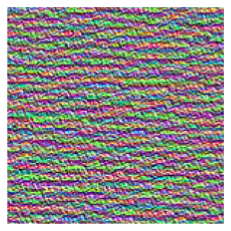

time: 5.38 s (started: 2021-07-31 22:20:51 +08:00)


In [21]:
plt.axis("off")
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))

看起来 block3_sepconv1 层中的过滤器 0 对水平线模式有反应，有点像水或毛皮。

现在是有趣的部分：您可以开始可视化层中的每个过滤器，甚至是模型中每个层中的每个过滤器。

> 清单 9.19 生成一个层中所有滤波器响应模式的网格

In [22]:
# 为图层中的前 64 个过滤器生成并保存可视化
all_images = []

for filter_index in range(64):
    print(f"Processing filter {filter_index}")
    image = deprocess_image(generate_filter_pattern(filter_index))
    all_images.append(image)

# 为我们准备一个空白画布以粘贴过滤器可视化
margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# 用我们保存的过滤器填充图片
for i in range(n): 
    for j in range(n):
        image = all_images[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = image

# Save the canvas to disk
keras.preprocessing.image.save_img( f"filters_for_layer_{layer_name}.png", stitched_filters)

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Pr

![](https://tva1.sinaimg.cn/large/008i3skNgy1gt0hy0gr5ij30jw0n0133.jpg)

这些过滤器可视化告诉您很多关于 convnet 层如何看待世界的信息：convnet 中的每一层都学习一组过滤器，以便它们的输入可以表示为过滤器的组合。 这类似于傅里叶变换如何将信号分解为一组余弦函数。 这些 convnet 过滤器组中的过滤器随着模型的提高而变得越来越复杂和精细：
* 模型中第一层的过滤器对简单的方向边缘和颜色（或在某些情况下有颜色的边缘）进行编码。
* 来自堆栈更上一层的过滤器，例如 block4_sepconv1，编码由边缘和颜色组合而成的简单纹理。
* 更高层中的过滤器开始类似于自然图像中的纹理：羽毛、眼睛、树叶等。

### 可视化类激活的热图

我们将介绍最后一种可视化技术——一种有助于理解给定图像的哪些部分导致 convnet 做出最终分类决策的技术。这有助于“调试”卷积网络的决策过程，特别是在分类错误的情况下（称为“模型可解释性”的问题域）。它还可以让您定位图像中的特定对象。

这种通用技术类别称为类激活图 (CAM) 可视化，它包括在输入图像上生成类激活热图。类激活热图是与特定输出类相关联的 2D 分数网格，为任何输入图像中的每个位置计算，指示每个位置相对于所考虑的类的重要性。例如，给定一个图像输入 dog-versus-cats convnet，CAM 可视化将允许您为“cat”类生成热图，指示图像的不同部分与猫的相似程度，以及“狗”类，表示图像的狗部分。

我们将使用的具体实现是“Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization”中描述的实现。

Grad-CAM 包括获取卷积层的输出特征图，给定输入图像，并通过类别相对于通道的梯度对该特征图中的每个通道进行加权。 直观地，理解这个技巧的一种方法是，您通过“每个通道对于类别的重要性”来加权“输入图像激活不同通道的强度”的空间图，从而得到“如何激活不同通道”的空间图 输入图像强烈地激活了课程。”

让我们使用预训练的 Xception 模型来演示这种技术。

> 清单 9.20 使用预训练权重加载 Xception 网络

In [23]:
# 请注意，您在顶部包含了密集连接的分类器； 在以前的所有情况下，您都丢弃了它。
model = keras.applications.xception.Xception(weights="imagenet")

91889664/91884032 [==============================] - 544s 6us/step
time: 9min 10s (started: 2021-07-31 22:28:09 +08:00)


考虑图 9.18 中显示的两只非洲象的图像，可能是母亲和她的小牛，在稀树草原上漫步。 让我们将此图像转换为 VGG16 模型可以读取的内容：该模型在大小为 299 × 299 的图像上进行训练，并根据封装在实用函数 `keras.applications.xception.preprocess_input` 中的一些规则进行了预处理。 因此，您需要加载图像，将其调整为 299 × 299，将其转换为 NumPy float32 张量，并应用这些预处理规则。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gt0i58jw8jj30uk0soq9g.jpg)

> 清单 9.21 为 Xception 预处理输入图像

In [ ]:
img_path = keras.utils.get_file(
    fname="elephant.jpg", #下载图像并将其存储在本地路径下。
    origin="https://img-datasets.s3.amazonaws.com/elephant.jpg") 

def get_img_array(img_path, target_size):
    
#     返回大小为 299 × 299 的 Python Imaging Library (PIL) 图像
    img = keras.preprocessing.image.load_img(img_path, target_size=target_size) 
    
#     返回一个 float32 NumPy 形状数组 (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img) 
    
#     添加维度以将数组转换为批量大小 (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0) 
    
#     预处理批次（这会进行通道颜色归一化）
    array = keras.applications.xception.preprocess_input(array) 
    return array

img_array = get_img_array(img_path, target_size=(299, 299))